# Es Beta Bank la mejor opción del mercado?

# Contents 

* [Introducción](#introduccion)
* [1. Inicialización](#inicializacion)
    * [1.1 Revisión de datos ausentes y duplicados](#ausentes)
    * [1.2 Revisión general de datos](#datos)
    * [1.3 Etiquetado de datos](#etiquetado) 
    * [1.4 Escalado de datos](#escalado)   
* [2. Definición de Features y Target](#features)
* [3. Segmentación de datos](#segmentacion)
    * [3.1 Balanceo de clases](#balanceo)
* [4. Modelos](#modelos)
    * [4.1 Modelo Decision Tree Classifier](#dtc)
    * [4.2 Modelo Random Forest Classifier](#rfc)
    * [4.3 Modelo Logistic Regression](#lr)
* [5. Balanceo de clases](#clases) 
    * [5.1 Ajuste por clases](#ajuste)
    * [5.2 Sobremuestreo](#upsampled)
    * [5.3 Submuestreo](#downsampled)
    * [5.4 Comparación de modelos](#comparativo)    
* [6. Evaluación del Modelo](#evaluacion)
* [7. AUC-ROC](#AUC)
    * [7.1 Curva AUC-ROC](#curva)
* [8. Conclusiones](#Conclusiones)

<div id="introduccion"/>

# Introducción

Beta Bank está investigando que tan probable es que sus actuales clientes continuen abandonando el banco, para ello solicitó la creación de un modelo que pueda predecir que tan probable es que esto suceda.

<div id="inicializacion"/>

## Inicialización

In [90]:
#Librerias
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from joblib import dump
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, recall_score, accuracy_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.dummy import DummyClassifier
import warnings
warnings.filterwarnings('ignore')

In [2]:
#carga de los datos
data = pd.read_csv("/datasets/Churn.csv")

In [3]:
#información de los datos
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


De acuerdo a la información suministrada, el DataFrame consta de 14 columnas y 10000 registros, se observa que los nombres de las columnas están en mayúsculas y sin separadores, por lo que se procederá a cambiar todas a minúsculas y con separadores.

In [5]:
#cambio a minúsculas y uso de '-'
columns = []
for name in data.columns.values:
    name = re.sub("([A-Z])", r' \1', name).lower().replace(' ', '_')[1:]
    columns.append(name)
    
data.columns = columns

In [6]:
data.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


<div id="ausentes"/>

### Revisión de datos ausentes y duplicados

In [7]:
#ausentes
data.isna().sum()

row_number            0
customer_id           0
surname               0
credit_score          0
geography             0
gender                0
age                   0
tenure              909
balance               0
num_of_products       0
has_cr_card           0
is_active_member      0
estimated_salary      0
exited                0
dtype: int64

La columna "tenure" tiene 909 datos nulos. No hay datos nulos en el resto de las columnas.

<AxesSubplot:>

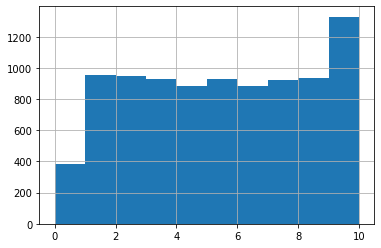

In [8]:
data["tenure"].hist()

In [9]:
data["tenure"].describe()

count    9091.000000
mean        4.997690
std         2.894723
min         0.000000
25%         2.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: tenure, dtype: float64

Se observa una distribución bastante uniforme, a excepción de los valores extremos en 0 y 10. Es posible que los valores nulos en esta columna se deban a que los clientes no cuentan con este rubro, por lo que se procederá a imputar con la mediana, que es practicamente igual a la media.

In [10]:
median_tenure = data["tenure"].median()
median_tenure

5.0

In [11]:
#imputación de datos ausentes
data["tenure"]= data["tenure"].fillna(median_tenure)
data["tenure"] = data["tenure"].astype(int)

In [12]:
data.isna().sum()

row_number          0
customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

In [13]:
#revisión de duplicados
data.duplicated().sum()

0

<div id="datos"/>

### Revisión general de datos

In [14]:
data.describe()

,row_number,customer_id,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.99790,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.76001,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.00000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.00000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.00000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.00000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.00000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Se observa algunas características que tienen diferente escalas("balance", "credit_score", "estimated_salary") que pueden afectar al modelo, por lo que a continuación las analizaremos en busca de alguna relación con la variable objetivo, la cual también será analizada. 

<AxesSubplot:>

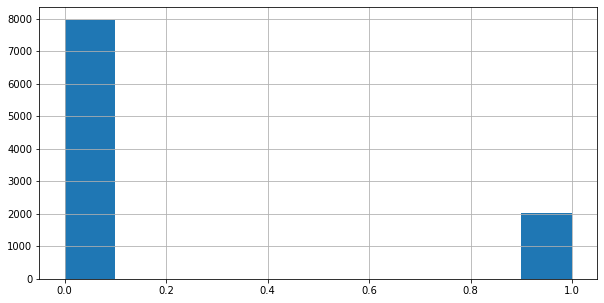

In [15]:
#histograma de la variable objetivo
data["exited"].hist(bins=10, figsize=(10,5))

In [16]:
data["exited"].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: exited, dtype: float64

De acuerdo a este gráfico la proporción de clientes que no se han ido(0) tripicla la cantidad de clientes que si se han cambiado de banco(1), por lo que se espera que el modelo, como punto de partida, tenga una exactitud mayor al 79%. Adicionalmente se observa que existen 3 columnas que no impactarán en el modelo por ser claves únicas: "row_number", customer_id" y "surname" por lo que pueden ser excluidas de las características. 

In [17]:
#eliminación de las columnas con código único
data.drop(["row_number", "customer_id", "surname"], axis=1, inplace=True)

<AxesSubplot:>

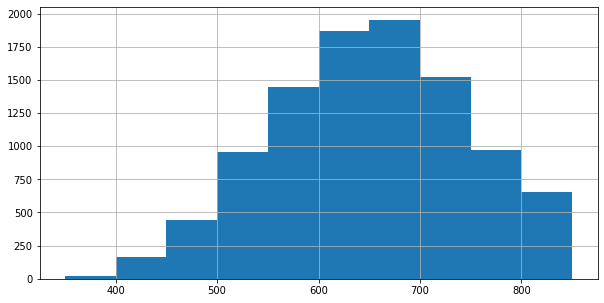

In [18]:
#revisión de la columna credit_score
data["credit_score"].hist(figsize=(10,5))

<AxesSubplot:>

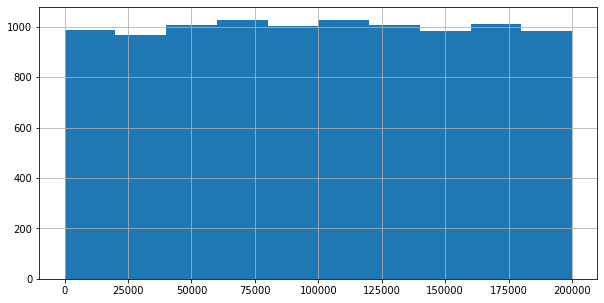

In [19]:
#revisión de la columna estomated_salary
data["estimated_salary"].hist(figsize=(10,5))

<AxesSubplot:>

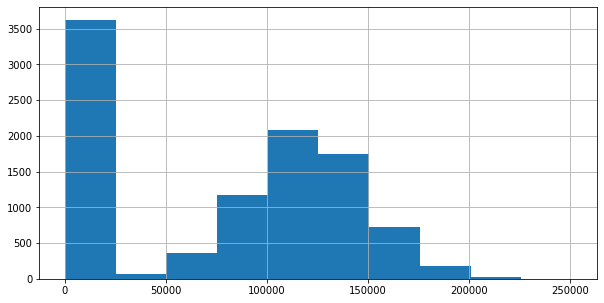

In [20]:
#revisión de la columna balance
data["balance"].hist(figsize=(10,5))

De esos 3 histogramas se observa:
1. La característica "credit_score" se asemeja a una distribución normal con una media y mediana alrededor de los 650.
2. La caracterítica "salary" tiene un comportamiento uniforme.
3. La característica "balance", a excepción del pico en 0 muestra una distribución similar a una normal. Se podría pensar que los altos valores en "0" para el balance se debe a los clientes que se fueron del banco, es decir, a los que tienen el valor de 1 en el target.

In [21]:
#relación entre la columna target (1: se han ido) y balance igual a 0
data.loc[(data["exited"]==1) & (data["balance"]==0)]

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2,0.0,1,1,1,101348.88,1
22,510,Spain,Female,38,4,0.0,1,1,0,118913.53,1
30,591,Spain,Female,39,5,0.0,3,1,0,140469.38,1
58,511,Spain,Female,66,4,0.0,1,1,0,1643.11,1
81,777,France,Female,32,2,0.0,1,1,0,136458.19,1
...,...,...,...,...,...,...,...,...,...,...,...
9784,527,France,Male,39,4,0.0,2,1,0,167183.07,1
9884,751,France,Female,48,4,0.0,1,0,1,30165.06,1
9898,589,France,Male,38,4,0.0,1,1,0,95483.48,1
9962,702,Spain,Male,44,9,0.0,1,0,0,59207.41,1


In [22]:
data["balance"].value_counts()

0.00         3617
105473.74       2
130170.82       2
72594.00        1
139723.90       1
             ... 
130306.49       1
92895.56        1
132005.77       1
166287.85       1
104001.38       1
Name: balance, Length: 6382, dtype: int64

Se observa que solo 500 registros de los 3617 (14%) clientes con balances "0" se fueron del banco, por lo que no se puede establecer claramente una relación, sin embargo, es un punto de partida para nuestro modelo.

In [23]:
#relación entre target y miembros activos
data.loc[(data["exited"]==1) & (data["is_active_member"]==0)]

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
5,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
7,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
16,653,Germany,Male,58,1,132602.88,1,1,0,5097.67,1
22,510,Spain,Female,38,4,0.00,1,1,0,118913.53,1
...,...,...,...,...,...,...,...,...,...,...,...
9962,702,Spain,Male,44,9,0.00,1,0,0,59207.41,1
9975,610,Germany,Male,50,1,113957.01,2,1,0,196526.55,1
9982,655,Germany,Female,46,7,137145.12,1,1,0,115146.40,1
9991,597,France,Female,53,4,88381.21,1,1,0,69384.71,1


In [24]:
data["is_active_member"].value_counts()

1    5151
0    4849
Name: is_active_member, dtype: int64

In [25]:
#relación entre target y tenencia de tarjeta de crédito
data.loc[(data["exited"]==1) & (data["has_cr_card"]==0)]

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
41,465,France,Female,51,8,122522.32,1,0,0,181297.65,1
43,834,France,Female,49,2,131394.56,1,0,0,194365.76,1
53,655,Germany,Male,41,5,125561.97,1,0,0,164040.94,1
114,721,Germany,Male,28,9,154475.54,2,0,1,101300.94,1
126,549,France,Female,52,1,0.00,1,0,1,8636.05,1
...,...,...,...,...,...,...,...,...,...,...,...
9884,751,France,Female,48,4,0.00,1,0,1,30165.06,1
9917,635,Germany,Male,53,8,117005.55,1,0,1,123646.57,1
9920,678,France,Female,49,3,204510.94,1,0,1,738.88,1
9962,702,Spain,Male,44,9,0.00,1,0,0,59207.41,1


In [26]:
data["has_cr_card"].value_counts()

1    7055
0    2945
Name: has_cr_card, dtype: int64

Observando la característica "is_active_member" donde 0 es no, se esperaría un alto porcentaje de clientes que no son miembros activos y que se han ido del banco, sin embargo, no es así, apenas el porcentaje es de 27%. Igual comportamiento se aprecia con la característica "has_cr_card" por lo que no hay una relación clara entre ellas y el target.

Text(0.5, 1.0, 'Proporción de clientes por país')

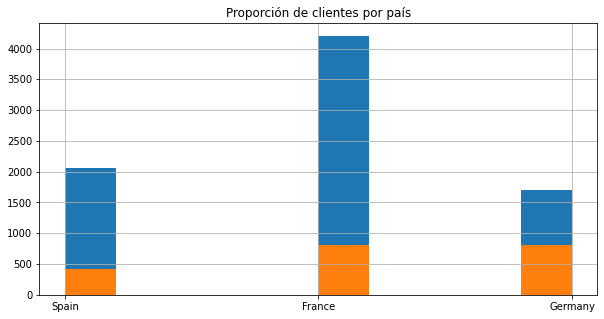

In [27]:
#relación entre target y ubicación gráfica
data.groupby("exited")["geography"].hist(figsize=(10,5))
plt.title("Proporción de clientes por país")

Text(0.5, 1.0, 'Proporción por género con Exited')

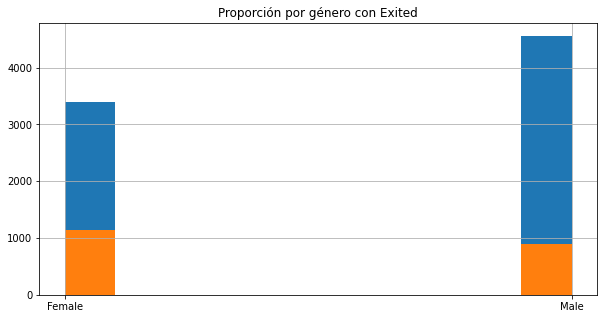

In [28]:
#relación entre género y target
data.groupby("exited")["gender"].hist(figsize=(10,5))
plt.title("Proporción por género con Exited")

De estas dos últimas gráficas se aprecia que:
1. Francia es el país donde el banco tiene mayor representación con una amplia cartera de clientes. 
2. En Alemania está balanceado la cantidad de clientes que abandonaron el banco y la cantidad de clientes que mantienen relación comercial con el banco.
2. Francia es el país que mayormente mantiene aún la cartera de clientes.
3. En España se observa mayor lealtad de los clientes con el banco.
4. La mayor cantidad de clientes que se han ido han sido mujeres.
5. La mayor cantidad de clientes son hombres.



<div id="etiquetado"/>

### Etiquetado de datos

In [29]:
#Revisión de las variables categóricas para su etiquetado
data["geography"].value_counts(normalize=True)

France     0.5014
Germany    0.2509
Spain      0.2477
Name: geography, dtype: float64

In [30]:
data["gender"].value_counts(normalize=True)

Male      0.5457
Female    0.4543
Name: gender, dtype: float64

In [31]:
data_OHE = pd.get_dummies(data, drop_first=True)

In [32]:
data_OHE.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


<div id="escalado"/>

### Escalado de datos

In [33]:
numeric = ["credit_score", "age", "balance", "estimated_salary"]
scaler = StandardScaler()
data_OHE[numeric] = pd.DataFrame(scaler.fit_transform(data_OHE[numeric]))

<div id="features"/>

## Definición de Features y Target

In [34]:
#definicion de features y target
features = data_OHE.drop("exited", axis=1)
target = data_OHE["exited"]

<div id="segmentacion"/>

## Segmentación de datos

In [38]:
#segmentación
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.40, random_state=12345)

In [39]:
#segmentación de datos para validación y prueba
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5, random_state=12345)

In [40]:
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)
print(target_train.shape)
print(target_valid.shape)
print(target_test.shape)

(6000, 11)
(2000, 11)
(2000, 11)
(6000,)
(2000,)
(2000,)


<div id="balanceo"/>

### Balanceo de clases

In [41]:
#Modelo constante
mod_constante = pd.Series(1, index=target)
print(f1_score(target, mod_constante))

0.3384564260197724


La exactitud para reproducir 1 en el modelo constante es muy baja, se aleja del 1 por lo que el modelo no está balanceado y esto afecta los resultados, sin embargo, como primera aproximación se tomará así.

<div id="modelos"/>

## Modelos

En este sección de realizará la evaluación utilizando los siguientes modelos:

1. Decision Tree Classifier
2. Random Forest Classifier
3. Logistic Regression

<div id="dtc"/>

### Modelo Decision Tree Classifier¶

Se selecciona como hiperparámetro:

max_depth = 20, para evaluar 19 ramas de profundidad en el árbol

In [42]:
best_model_dtc = None
best_result_dtc = 0
valid_aprox_dtc = []
max_depth_range = [i for i in range(1, 20)]
for depth in max_depth_range:
    model_dtc = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_dtc.fit(features_train, target_train)
    
    #predicción con datos de validación
    prediction_dtc_valid = model_dtc.predict(features_valid)
    result_dtc_valid = f1_score(target_valid, prediction_dtc_valid)
    valid_aprox_dtc.append(result_dtc_valid)
    
    if result_dtc_valid > best_result_dtc:
        best_model_dtc = model_dtc
        best_result_dtc = result_dtc_valid
        i = depth
    print("max_depth = ", depth , "f1 en modelo de validacion:", result_dtc_valid)

max_depth =  1 f1 en modelo de validacion: 0.0
max_depth =  2 f1 en modelo de validacion: 0.5217391304347825
max_depth =  3 f1 en modelo de validacion: 0.4234875444839857
max_depth =  4 f1 en modelo de validacion: 0.5528700906344411
max_depth =  5 f1 en modelo de validacion: 0.5406249999999999
max_depth =  6 f1 en modelo de validacion: 0.5696969696969697
max_depth =  7 f1 en modelo de validacion: 0.5320813771517998
max_depth =  8 f1 en modelo de validacion: 0.5454545454545454
max_depth =  9 f1 en modelo de validacion: 0.5633802816901409
max_depth =  10 f1 en modelo de validacion: 0.5406162464985994
max_depth =  11 f1 en modelo de validacion: 0.5079787234042553
max_depth =  12 f1 en modelo de validacion: 0.5217391304347826
max_depth =  13 f1 en modelo de validacion: 0.5064935064935066
max_depth =  14 f1 en modelo de validacion: 0.489281210592686
max_depth =  15 f1 en modelo de validacion: 0.5
max_depth =  16 f1 en modelo de validacion: 0.5018541409147095
max_depth =  17 f1 en modelo de 

In [43]:
print("El mayor f1 logrado es de:", best_result_dtc, "en la profundidad de:", i)

El mayor f1 logrado es de: 0.5696969696969697 en la profundidad de: 6


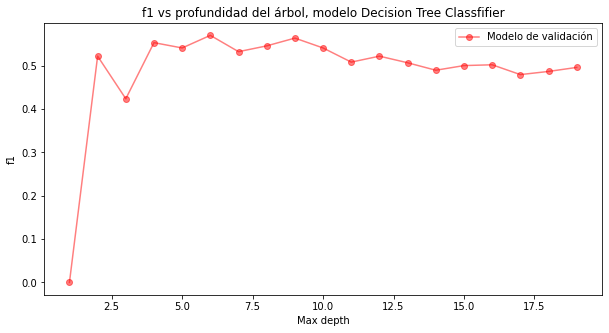

In [44]:
plt.figure(figsize=(10,5))
plt.plot(max_depth_range, valid_aprox_dtc, '-o', color = "red", label = "Modelo de validación", alpha = 0.5)
plt.title("f1 vs profundidad del árbol, modelo Decision Tree Classfifier")
plt.xlabel("Max depth")
plt.ylabel("f1")
plt.legend()
plt.show()

Analizando los resultados se observa que a medida que la profundidad crece, después de alcanzar el máximo en 0.57(profundidad de 6), f1 en el modelo de validación disminuye.

<div id="rfc"/>

### Modelo Random Forest Classifier

Se considera como hiperparámetro:
est = 12

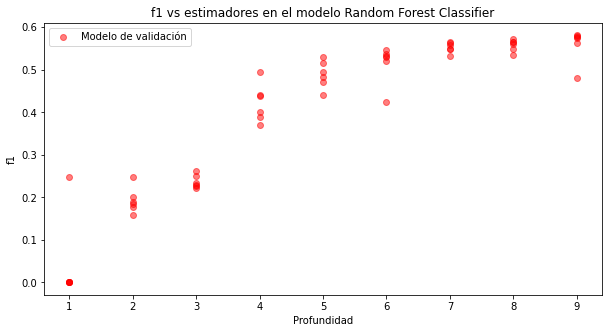

In [45]:
estimator_range = [i for i in range(1, 51, 9)]
valid_aprox_rfc = [] 
depth_list = []
best_model_rfc = None
best_result_rfc = 0
i = 0

for est in estimator_range:
    for depth in range(1,10):
        model_rfc = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model_rfc.fit(features_train, target_train)
            
        # predicción en modelo de validación
        prediction_rfc_valid = model_rfc.predict(features_valid)
        result_rfc_valid = f1_score(target_valid, prediction_rfc_valid)
        valid_aprox_rfc.append(result_rfc_valid)
        depth_list.append(depth)
        
        if result_rfc_valid > best_result_rfc:
            best_model_rfc = model_rfc
            best_result_rfc = result_rfc_valid
            j = est
            k = depth
        
        
plt.figure(figsize=(10,5))

plt.plot(depth_list, valid_aprox_rfc, "o", label = "Modelo de validación", color="red", alpha = 0.5)
plt.title("f1 vs estimadores en el modelo Random Forest Classifier")
plt.xlabel("Profundidad")
plt.ylabel("f1")
plt.legend()   

In [46]:
print("El mayor valor de f1 logrado es de:", best_result_rfc, "en la estimación:", j, "depth:", k)

El mayor valor de f1 logrado es de: 0.5809379727685325 en la estimación: 10 depth: 9


De los resultados se desprende que a medida que aumenta el número de estimadores se incrementa la exactitud pero la corrida del modelo se hace más lenta. En la profundidad de 9 se observa el mayor valor de f1, independiente del estimador.

<div id="lr"/>

### Modelo Logistic Regression

In [47]:
solv = ['liblinear','newton-cg', 'lbfgs','sag', 'saga']
for element in solv:
    model_lr_s = LogisticRegression(random_state=12345, solver=element, max_iter=100000)
    model_lr_s.fit(features_train, target_train)
    predictions_lr_s = model_lr_s.predict(features_valid)
    result_lr_s = f1_score(target_valid, predictions_lr_s)
    print("f1 es de:", result_lr_s, "con el método:", element)

f1 es de: 0.33108108108108103 con el método: liblinear
f1 es de: 0.33108108108108103 con el método: newton-cg
f1 es de: 0.33108108108108103 con el método: lbfgs
f1 es de: 0.33108108108108103 con el método: sag
f1 es de: 0.33108108108108103 con el método: saga


De los 3 modelos estudiados se observa que el modelo Decision Tree Classifier es el que arroja mayor valor de f1(0.58) y el modelo Linear Regresion es el que menor valor de f1 arroja(0.33), sin embargo, están por debajo del valor solicitado. Se procederá a continuación a realizar el balanceo de las clases.

<div id="clases"/>

## Balanceo de clases

Se procederá a realizar el balanceo a través de 3 métodos
1. Ajuste por clases
2. Sobremuestreo (upsampled)
3. Submuestreo (downsampled)

<div id="ajuste"/>

### Ajuste por clases


In [48]:
#Decision Tree Classifier
best_model_dtc_balanced = None
best_result_dtc_balanced = 0
valid_aprox_dtc_balanced = []
max_depth_range_balanced = [i for i in range(1, 20)]
for depth in max_depth_range_balanced:
    model_dtc_balanced = DecisionTreeClassifier(random_state=12345, class_weight="balanced", max_depth=depth)
    model_dtc_balanced.fit(features_train, target_train)
    prediction_dtc_valid_balanced = model_dtc_balanced.predict(features_valid)
    result_dtc_valid_balanced = f1_score(target_valid, prediction_dtc_valid_balanced)
    valid_aprox_dtc_balanced.append(result_dtc_valid_balanced)
    
    if result_dtc_valid_balanced > best_result_dtc_balanced:
        best_model_dtc_balanced = model_dtc_balanced
        best_result_dtc_balanced = result_dtc_valid_balanced
        i = depth
print("El mayor f1 logrado es de:", best_result_dtc_balanced, "en la profundidad de:", i)

El mayor f1 logrado es de: 0.5963791267305644 en la profundidad de: 5


In [49]:
#Random Forest Classifier
estimator_range_balanced = [i for i in range(1, 51, 9)]
valid_aprox_rfc_balanced = [] 
depth_list_balanced = []
best_model_rfc_balanced = None
best_result_rfc_balanced = 0
i = 0

for est in estimator_range_balanced:
    for depth in range(1,10):
        model_rfc_balanced = RandomForestClassifier(random_state=12345, class_weight="balanced", n_estimators=est, max_depth=depth)
        model_rfc_balanced.fit(features_train, target_train)
        prediction_rfc_valid_balanced = model_rfc_balanced.predict(features_valid)
        result_rfc_valid_balanced = f1_score(target_valid, prediction_rfc_valid_balanced)
        valid_aprox_rfc_balanced.append(result_rfc_valid_balanced)
        depth_list_balanced.append(depth)
        if result_rfc_valid_balanced > best_result_rfc_balanced:
            best_model_rfc_balanced = model_rfc_balanced
            best_result_rfc_balanced = result_rfc_valid_balanced
            j = est
            k = depth
print("El mayor valor de f1 logrado es de:", best_result_rfc_balanced, "en la estimación:", j, "depth:", k)       

El mayor valor de f1 logrado es de: 0.6247288503253796 en la estimación: 46 depth: 8


In [50]:
#Linear Regression
solv = ['liblinear','newton-cg', 'lbfgs','sag', 'saga']
for element in solv:
    model_lr_s_balanced = LogisticRegression(random_state=12345, class_weight="balanced", solver=element, max_iter=100000)
    model_lr_s_balanced.fit(features_train, target_train)
    predictions_lr_s_balanced = model_lr_s_balanced.predict(features_valid)
    result_lr_s_balanced = f1_score(target_valid, predictions_lr_s_balanced)
    print("f1 es de:", result_lr_s_balanced, "con el método:", element)

f1 es de: 0.4888507718696398 con el método: liblinear
f1 es de: 0.4888507718696398 con el método: newton-cg
f1 es de: 0.4888507718696398 con el método: lbfgs
f1 es de: 0.4888507718696398 con el método: sag
f1 es de: 0.4888507718696398 con el método: saga


Con el ajuste por clases, el modelo Random Forest Classifier arrojó el mayor valor de f1(62%).

<div id="upsampled"/>

### Sobremuestreo

In [56]:
#Definición de función
def upsample(features, target, repeat):
    features_zeros = features_train[target_train==0]
    features_ones = features_train[target_train==1]
    target_zeros = target_train[target_train==0]
    target_ones = target_train[target_train==1]
    repeat=10
    features_upsampled = pd.concat([features_zeros]+[features_ones]*repeat)
    target_upsampled = pd.concat([target_zeros]+[target_ones]*repeat)
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled
features_upsampled, target_upsampled = upsample(features_train, target_train, 10)
print(features_upsampled.shape)
print(target_upsampled.shape)


(16764, 11)
(16764,)


In [57]:
#Decision Tree Classifier
best_model_dtc_up = None
best_result_dtc_up = 0
valid_aprox_dtc_up = []
max_depth_range_up = [i for i in range(1, 20)]
for depth in max_depth_range_up:
    model_dtc_up = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_dtc_up.fit(features_upsampled, target_upsampled)
    prediction_dtc_valid_up = model_dtc_up.predict(features_valid)
    result_dtc_valid_up = f1_score(target_valid, prediction_dtc_valid_up)
    valid_aprox_dtc_up.append(result_dtc_valid_up)
    
    if result_dtc_valid_up > best_result_dtc_up:
        best_model_dtc_up = model_dtc_up
        best_result_dtc_up = result_dtc_valid_up
        i = depth
print("El mayor f1 logrado es de:", best_result_dtc_up, "en la profundidad de:", i)

El mayor f1 logrado es de: 0.5251572327044025 en la profundidad de: 7


In [58]:
#Random Forest Classifier
estimator_range_up = [i for i in range(1, 51, 9)]
valid_aprox_rfc_up = [] 
depth_list_up = []
best_model_rfc_up = None
best_result_rfc_up = 0
i = 0

for est in estimator_range_up:
    for depth in range(1,10):
        model_rfc_up = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model_rfc_up.fit(features_upsampled, target_upsampled)
        prediction_rfc_valid_up = model_rfc_up.predict(features_valid)
        result_rfc_valid_up = f1_score(target_valid, prediction_rfc_valid_up)
        valid_aprox_rfc_up.append(result_rfc_valid_up)
        depth_list_up.append(depth)
        if result_rfc_valid_up > best_result_rfc_up:
            best_model_rfc_up = model_rfc_up
            best_result_rfc_up = result_rfc_valid_up
            j = est
            k = depth
print("El mayor valor de f1 logrado es de:", best_result_rfc_up, "en la estimación:", j, "depth:", k)

El mayor valor de f1 logrado es de: 0.5458786936236392 en la estimación: 28 depth: 9


In [59]:
#Linear Regression
solv = ['liblinear','newton-cg', 'lbfgs','sag', 'saga']
for element in solv:
    model_lr_s_up = LogisticRegression(random_state=12345, solver=element, max_iter=100000)
    model_lr_s_up.fit(features_upsampled, target_upsampled)
    predictions_lr_s_up = model_lr_s_up.predict(features_valid)
    result_lr_s_up = f1_score(target_valid, predictions_lr_s_up)
    print("f1 es de:", result_lr_s_up, "con el método:", element)

f1 es de: 0.4194260485651214 con el método: liblinear
f1 es de: 0.4194260485651214 con el método: newton-cg
f1 es de: 0.4194260485651214 con el método: lbfgs
f1 es de: 0.4194260485651214 con el método: sag
f1 es de: 0.4194260485651214 con el método: saga


Comparando los resultados obtenidos con el Sobremuestreo en los 3 modelos analizados encontramos que Random Forest Classifier presenta el valor más alto de f1(0.55).

<div id="downsampled"/>

### Submuestreo

In [61]:
#Definición de función
def downsample(features, target, fraction):
    features_zeros = features_train[target_train==0]
    features_ones = features_train[target_train==1]
    target_zeros = target_train[target_train==0]
    target_ones = target_train[target_train==1]
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)]+[features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)]+[target_ones])
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)
    return features_downsampled, target_downsampled
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)
print(features_downsampled.shape)
print(target_downsampled.shape)

(1676, 11)
(1676,)


In [62]:
#Decision Tree Classifier
best_model_dtc_down = None
best_result_dtc_down = 0
valid_aprox_dtc_down = []
max_depth_range = [i for i in range(1, 20)]
for depth in max_depth_range:
    model_dtc_down = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_dtc_down.fit(features_downsampled, target_downsampled)
    prediction_dtc_valid_down = model_dtc_down.predict(features_valid)
    result_dtc_valid_down = f1_score(target_valid, prediction_dtc_valid_down)
    valid_aprox_dtc_down.append(result_dtc_valid_down)
    
    if result_dtc_valid_down > best_result_dtc_down:
        best_model_dtc_down = model_dtc_down
        best_result_dtc_down = result_dtc_valid_down
        i = depth
print("El mayor f1 logrado es de:", best_result_dtc_down, "en la profundidad de:", i)

El mayor f1 logrado es de: 0.49553877831159915 en la profundidad de: 5


In [63]:
#Random Forest Classifier
estimator_range_down = [i for i in range(1, 51, 9)]
valid_aprox_rfc_down = [] 
depth_list_down = []
best_model_rfc_down = None
best_result_rfc_down = 0
i = 0

for est in estimator_range_down:
    for depth in range(1,10):
        model_rfc_down = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model_rfc_down.fit(features_downsampled, target_downsampled)
        prediction_rfc_valid_down = model_rfc_down.predict(features_valid)
        result_rfc_valid_down = f1_score(target_valid, prediction_rfc_valid_down)
        valid_aprox_rfc_down.append(result_rfc_valid_down)
        depth_list_down.append(depth)
        if result_rfc_valid_down > best_result_rfc_down:
            best_model_rfc_down = model_rfc_down
            best_result_rfc_down = result_rfc_valid_down
            j = est
            k = depth
print("El mayor valor de f1 logrado es de:", best_result_rfc_down, "en la estimación:", j, "depth:", k)

El mayor valor de f1 logrado es de: 0.467324290998767 en la estimación: 28 depth: 9


In [64]:
#Linear Regression
solv = ['liblinear','newton-cg', 'lbfgs','sag', 'saga']
for element in solv:
    model_lr_s_down = LogisticRegression(random_state=12345, solver=element, max_iter=100000)
    model_lr_s_down.fit(features_downsampled, target_downsampled)
    predictions_lr_s_down = model_lr_s_down.predict(features_valid)
    result_lr_s_down = f1_score(target_valid, predictions_lr_s_down)
    print("f1 es de:", result_lr_s_down, "con el método:", element)

f1 es de: 0.4303510758776898 con el método: liblinear
f1 es de: 0.42986425339366513 con el método: newton-cg
f1 es de: 0.42986425339366513 con el método: lbfgs
f1 es de: 0.42986425339366513 con el método: sag
f1 es de: 0.42986425339366513 con el método: saga


Para el método de submuestreo el mayor valor de f1 alcanzado fue de 50% en el modelo Decision Tree Classifier, seguido por el modelo Random Forest Classifier con 47% y por último el de Linear Regression con 43%.

<div id="comparativo"/>

### Comparación de modelos

Se procede a comparar los resultados obtenidos por los 3 modelos con los 3 métodos utilizados.

In [83]:
print("   f1            Decision Tree Classifier","    Random Forest Classifier")
print(f"sin ajuste de clase     {best_result_dtc:.2%},                    {best_result_rfc:.2%}")
print(f"ajuste de clase         {best_result_dtc_balanced:.2%},                    {best_result_rfc_balanced:.2%}")
print(f"sobreajuste             {best_result_dtc_up:.2%},                    {best_result_rfc_up:.2%}")
print(f"subajuste               {best_result_dtc_down:.2%},                    {best_result_rfc_down:.2%}")

   f1            Decision Tree Classifier     Random Forest Classifier
sin ajuste de clase     56.97%,                    58.09%
ajuste de clase         59.64%,                    62.47%
sobreajuste             52.52%,                    54.59%
subajuste               49.55%,                    46.73%


El mejor modelo que se ajustó fue el de ajuste de clases para Random Forest Classifier con 62% y sobre este modelo se realizará el ajuste de los datos de prueba.

<div id="evaluacion"/>

## Evaluación del modelo

Se procederá a evaluar el modelo de entrenamiento (Random Forest Classifier) en el dataset de prueba y en el dataset general.

In [84]:
def eval_modelo(f_train, t_train, f, t, f_test, t_test):
    model_test = RandomForestClassifier(random_state=12345, class_weight = "balanced", n_estimators = 46, max_depth=8)
    model_test.fit(f_train, t_train)
    predictions_test = model_test.predict(f_test)
    result_test = f1_score(t_test, predictions_test)
    
    model_data = RandomForestClassifier(random_state=12345,  class_weight = "balanced", n_estimators = 46, max_depth=8)
    model_data.fit(f_train, t_train)
    predictions_data = model_data.predict(f)
    result_data = f1_score(t, predictions_data)
    print("f1 del modelo Random Forest Classifier en dataset de prueba:", result_test*100)
    print("f1 del modelo Random Forest Classifier en dataset completa:", result_data*100)
eval_modelo(features_train, target_train, features, target, features_test, target_test)

f1 del modelo Random Forest Classifier en dataset de prueba: 60.36916395222583
f1 del modelo Random Forest Classifier en dataset completa: 66.874582312319


Los valores de f1 obtenidos tanto para el conjunto de datos de prueba como para el dataset completo supera el 0.59

<div id="AUC"/>

## AUC-ROC

Se procederá a realizar la curva AUC-ROC 

In [89]:
model_test = RandomForestClassifier(random_state=12345, class_weight = "balanced", n_estimators = 46, max_depth=8)
model_test.fit(features_train, target_train)
probabilities = model_test.predict_proba(features_test)
probabilities_one_test = probabilities[:,1]
auc_roc = round(roc_auc_score(target_test, probabilities_one_test)*100,2)
print(auc_roc)

85.48


<div id="curva"/>

### Curva AUC-ROC

In [91]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test) 

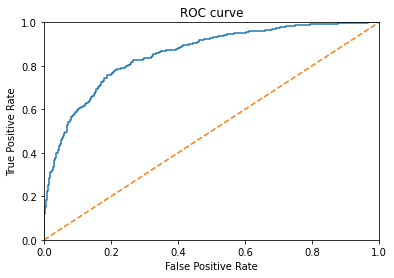

In [92]:
plt.figure()
plt.plot(fpr, tpr)
# ROC curve for random model (looks like a straight line)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('ROC curve')
plt.show()

<div id="conclusiones"/>

## Conclusiones

1. El DataFrame original contiene 14 columnas y 10000 registros.
2. La columna "tenure" tiene datos ausentes, que fueron imputados con la mediana.
3. No hay datos duplicados.
4. El dataset fue seccionado en 60% para el modelo de entrenamiento y del 40% restante se destinaron 50% para datos de validación y 50% datos de prueba.
5. Se excluyeron del análisis las características "customer_id", "row_number" y "surname" por ser códigos únicos.
6. Se etiquetaron las variables categóricas de "genre" y "geography".
7. Se escalaron las características "credit_score", "balance" y "estimated_salary".
8. Sin balancear las clases, el mejor modelo que hizo las predicciones fue el Random Forest Classifier y los más alejados fueron el modelo constante y el linear regression.
9. Se hizo balance de clases empleando "ajuste de clases", "sobremuestreo", "submuestreo", determinando que el modelo que mejor se ajusto (mayor f1) fue Random Forest Classifier con los hiperparámetros: n_estimators=46, depth=8 y class_weight="balanced".
10. La evaluación del modelo Random Forest Classifier en los datos de prueba arrojó un f1 de 60% y en la data completa 67%.
11. El AUC-ROC fue de 85%.


